In [1]:
# Import packagaes

# Basic packages
import numpy as np
import copy

# For plotting
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# To read fits file
from astropy.nddata import CCDData, Cutout2D

In [55]:
plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = 'cm'
# plt.rcParams['figure.figsize']=[4,3.5]
plt.rcParams['font.size']=20
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True

In [180]:
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
import astropy.units as u

# coord = SkyCoord(ra=84.218*u.deg, dec=31.2100*u.deg)
# query = SDSS.query_region(coord)
r = SDSS.get_images(camcol=6, field=34, run=6573, rerun=301, band='r')[0]
r.writeto('koposovo36_r.fits', overwrite=True)
g = SDSS.get_images(camcol=6, field=34, run=6573, rerun=301, band='g')[0]
g.writeto('koposovo36_g.fits', overwrite=True)

i = SDSS.get_images(camcol=6, field=34, run=6573, rerun=301, band='i')[0]
i.writeto('koposovo36_i.fits', overwrite=True)
z = SDSS.get_images(camcol=6, field=34, run=6573, rerun=301, band='z')[0]
z.writeto('koposovo36_z.fits', overwrite=True)

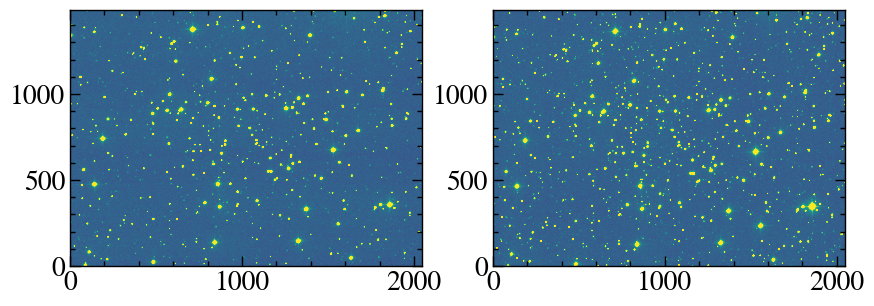

In [126]:
# Read fits data

# Save fits data in the list
data = [g[0].data, r[0].data]

# Plot the orginal image
# You may not need to change below
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
for i, dat in enumerate(data):
    scaler = ZScaleInterval()
    vmin, vmax = scaler.get_limits(dat)
    ax[i].imshow(dat, vmin=vmin, vmax=vmax, origin='lower')

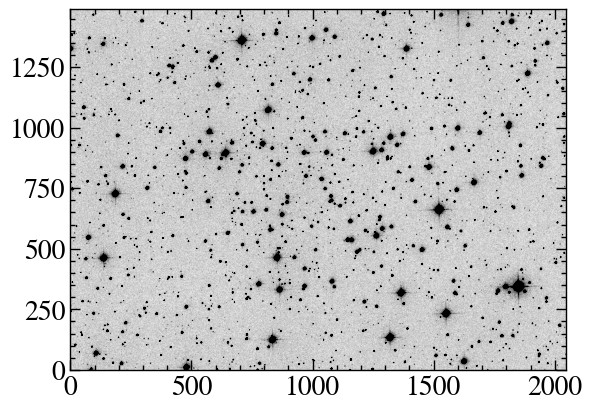

In [127]:
scaler = ZScaleInterval()
vmin, vmax = scaler.get_limits(data[0])

fig, ax = plt.subplots(1,1)
ax.imshow(r[0].data, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')

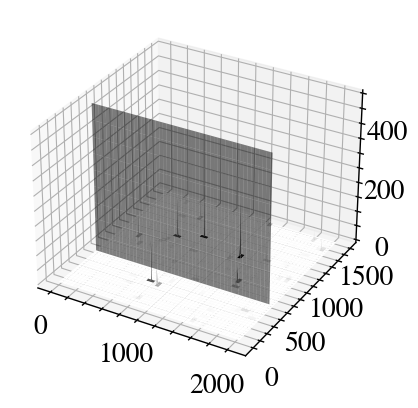

In [129]:
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of x, y coordinates
x = np.arange(r[0].data.shape[1])
y = np.arange(r[0].data.shape[0])
x, y = np.meshgrid(x, y)

# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, r[0].data.data, cmap='Greys')

# ax.set_zscale('log')
# ax.set_xlim(0,2000)
# ax.set_ylim(0,2000)

xx = np.linspace(0, 2000, 100)
Y = 500
zz = np.linspace(0, 500, 10)
xx, zz = np.meshgrid(xx, zz)
yy = np.full_like(xx, Y)

ax.plot_surface(xx, yy, zz, color='k', alpha=0.5)

(-0.1, 0.7)

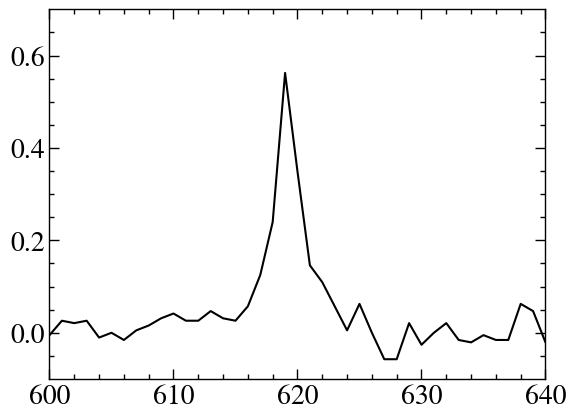

In [132]:
plt.plot(r[0].data[1000,100:-100], 'k-')
plt.xlim(600,640)
plt.ylim(-0.1,0.7)

In [96]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats

(<matplotlib.patches.Circle at 0x7fe5347ea520>,)

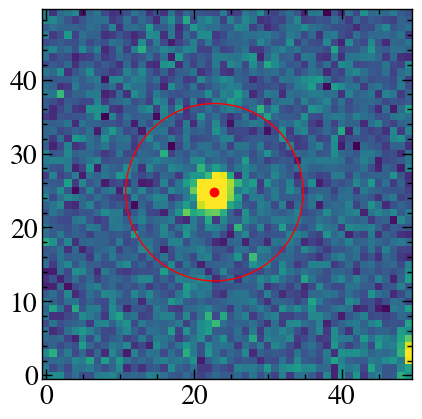

In [112]:
thres = 3
fwhm=4

cut = copy.deepcopy(data[0][985:1035,700:750])

scaler = ZScaleInterval()
vmin, vmax = scaler.get_limits(data[0])

avg, med, std = sigma_clipped_stats(cut.data) # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
finder = DAOStarFinder(threshold=thres*std, fwhm=fwhm, exclude_border=True) # set a finder to detect a star
sources = finder(cut.data - med) # detect stars. median is subtracted to minize the cotamination by the background
pos = np.transpose((sources['xcentroid'], sources['ycentroid'])) # save the position of the stars

# Set apertures
aper = CircularAperture(pos[0], r=4*3)

starphot = ApertureStats(cut, aper) # take statistics of the pixel values within the area of the stars

fig, ax = plt.subplots(1,1)
ax.imshow(cut, vmin=vmin, vmax=vmax, origin='lower')
ax.scatter(pos[0][0], pos[0][1], color='r')
aper.plot(ax, color='r')

(<matplotlib.patches.PathPatch at 0x7fe55412d340>,)

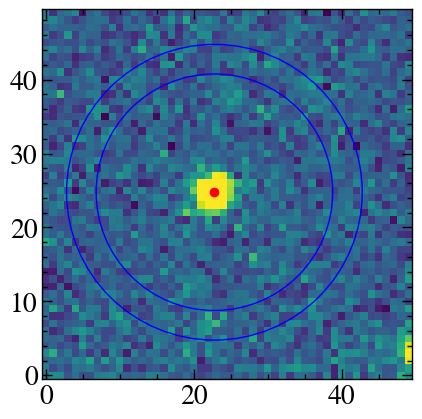

In [113]:
cut = copy.deepcopy(data[0][985:1035,700:750])

scaler = ZScaleInterval()
vmin, vmax = scaler.get_limits(data[0])

avg, med, std = sigma_clipped_stats(cut.data) 
finder = DAOStarFinder(threshold=thres*std, fwhm=fwhm, exclude_border=True) 
sources = finder(cut.data - med) 
pos = np.transpose((sources['xcentroid'], sources['ycentroid'])) 
# Set apertures
aper = CircularAperture(pos[0], r=4*3)
# Set annulus
annul = CircularAnnulus(pos[0], r_in=4*4, r_out=4*5)

fig, ax = plt.subplots(1,1)
ax.imshow(cut, vmin=vmin, vmax=vmax, origin='lower')
ax.scatter(pos[0][0], pos[0][1], color='r')
annul.plot(ax, color='b')

Text(0, 0.5, 'Mag')

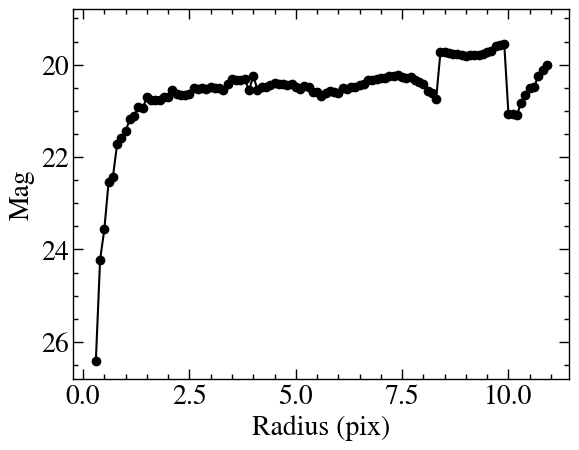

In [122]:
def flux_r(radia):
    mag = np.zeros_like(radia).astype(float)
    for i,r in enumerate(radia):
        cut = copy.deepcopy(data[0][985:1035,700:750])

        scaler = ZScaleInterval()
        vmin, vmax = scaler.get_limits(data[0])

        avg, med, std = sigma_clipped_stats(cut.data) # taking the statistics of the image with sigma clipping. Default clipping threshold is 3*sigma
        finder = DAOStarFinder(threshold=thres*std, fwhm=fwhm, exclude_border=True) # set a finder to detect a star
        sources = finder(cut.data - med) # detect stars. median is subtracted to minize the cotamination by the background
        pos = np.transpose((sources['xcentroid'], sources['ycentroid'])) # save the position of the stars
        # Set apertures
        aper = CircularAperture(pos[0], r=2*r)
        starphot = ApertureStats(cut, aper) # take statistics of the pixel values within the area of the stars

        # Set annulus
        annul = CircularAnnulus(pos[0], r_in=2*r*5/4, r_out=2*r*6/4)
        bkgphot = ApertureStats(cut, annul) # take statistics of the pixel values within the annuluses
        mode_bkg = 2.5*bkgphot.median-1.5*bkgphot.mean
        mag[i] = starphot.sum - aper.area * mode_bkg
    
    return mag

r = np.arange(0.1,11,0.1)
mag = -2.5*np.log10(flux_r(r))+22.5

plt.plot(r, mag, 'ko-')
plt.ylim(26.8, 18.8)
plt.xlabel('Radius (pix)')
plt.ylabel('Mag')

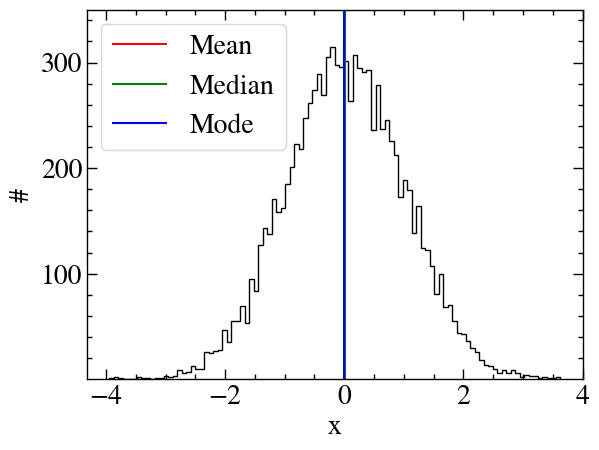

In [123]:
np.random.seed(50)
x = np.random.normal(size=10000)
plt.hist(x, bins=100, histtype='step', color='k')
plt.ylabel('#')
plt.xlabel('x')
plt.ylim(0.00001,350)
plt.vlines(np.mean(x),0,500,label='Mean', color='r')
plt.vlines(np.median(x),0,500,label='Median', color='g')
plt.vlines(2.5*np.median(x)-1.5*np.mean(x),0,500,label='Mode', color='b')
plt.legend(loc='upper left')

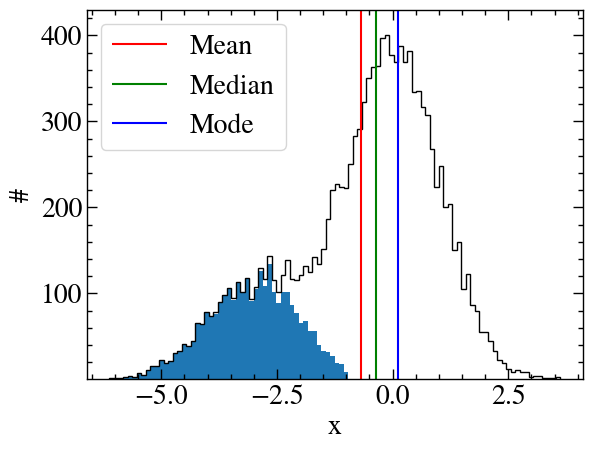

In [124]:
np.random.seed(50)
x = np.random.normal(size=10000)
conta = np.random.normal(size=3000, loc=-3)
conta = conta[conta<-1]
x = np.concatenate([x,conta])
hist = plt.hist(x, bins=100, histtype='step', color='k')
plt.hist(conta, bins=hist[1])
plt.ylabel('#')
plt.xlabel('x')
plt.ylim(0.00001,430)
plt.vlines(np.mean(x),0,500,label='Mean', color='r')
plt.vlines(np.median(x),0,500,label='Median', color='g')
plt.vlines(2.5*np.median(x)-1.5*np.mean(x),0,500,label='Mode', color='b')
plt.legend(loc='upper left')

In [163]:
from astropy.io import fits
from astropy.coordinates import SkyCoord

files = ['jw01334003001_04101_00001_nrca1_i2d.fits', 'jw01334003001_04101_00001_nrca2_i2d.fits',
         'jw01334003001_04101_00001_nrca3_i2d.fits', 'jw01334003001_04101_00001_nrca4_i2d.fits',
         'jw01334003001_04101_00001_nrcb1_i2d.fits', 'jw01334003001_04101_00001_nrcb2_i2d.fits',
         'jw01334003001_04101_00001_nrcb3_i2d.fits', 'jw01334003001_04101_00001_nrcb4_i2d.fits']

fits_list = [fits.open(file)[1] for file in files]
from reproject.mosaicking import find_optimal_celestial_wcs
wcs_out, shape_out = find_optimal_celestial_wcs(fits_list, auto_rotate=True)

Set DATE-AVG to '2022-07-04T00:51:34.814' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.651' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282049.535 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.878' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.715' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282050.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.749' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.586' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282048.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [175]:
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
array, footprint = reproject_and_coadd(fits_list,
                                       wcs_out, shape_out=shape_out,
                                       reproject_function=reproject_interp)

new_header = fits.Header()
new_header.update(wcs_out.to_header())
new_hdu = fits.PrimaryHDU(data=array, header=new_header)

# Create a HDUList to contain the HDU and write to a FITS file
hdulist = fits.HDUList([new_hdu])
hdulist.writeto('f150w.fits', overwrite=True)


Set DATE-AVG to '2022-07-04T00:51:34.814' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.651' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282049.535 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.814' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.651' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282049.535 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.878' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.715' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282050.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.878' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.715' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282050.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

In [177]:
from astropy.io import fits
from astropy.coordinates import SkyCoord

files = ['jw01334003001_04101_00001_nrcalong_i2d.fits', 'jw01334003001_04101_00001_nrcblong_i2d.fits']

fits_list = [fits.open(file)[1] for file in files]
from reproject.mosaicking import find_optimal_celestial_wcs
wcs_out, shape_out = find_optimal_celestial_wcs(fits_list, auto_rotate=True)

Set DATE-AVG to '2022-07-04T00:51:34.878' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.715' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282050.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.749' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.586' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282048.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [179]:
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
array, footprint = reproject_and_coadd(fits_list,
                                       wcs_out, shape_out=shape_out,
                                       reproject_function=reproject_interp)

new_header = fits.Header()
new_header.update(wcs_out.to_header())
new_hdu = fits.PrimaryHDU(data=array, header=new_header)

# Create a HDUList to contain the HDU and write to a FITS file
hdulist = fits.HDUList([new_hdu])
hdulist.writeto('f360m.fits', overwrite=True)

Set DATE-AVG to '2022-07-04T00:51:34.878' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.715' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282050.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T00:51:34.749' from MJD-AVG.
Set DATE-END to '2022-07-04T01:03:55.586' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.277307 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737282048.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [174]:
wcs_out.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      4995.1590387251 / Pixel coordinate of reference point            
CRPIX2  =      2174.4445038111 / Pixel coordinate of reference point            
PC1_1   =     0.80602128314847 / Coordinate transformation matrix element       
PC1_2   =     0.59188655256872 / Coordinate transformation matrix element       
PC2_1   =    -0.59188655256872 / Coordinate transformation matrix element       
PC2_2   =     0.80602128314847 / Coordinate transformation matrix element       
CDELT1  = -8.5404196657044E-06 / [deg] Coordinate increment at reference point  
CDELT2  =  8.5404196657044E-06 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'        

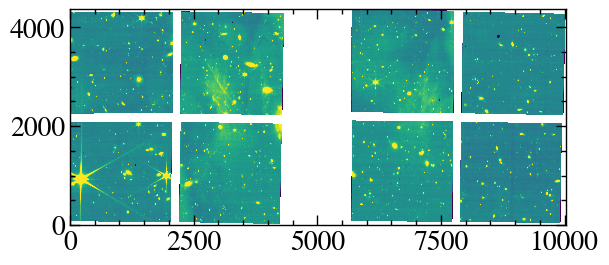

In [165]:
scaler = ZScaleInterval()
vmin, vmax = scaler.get_limits(array)
plt.imshow(array, vmin=vmin, vmax=vmax, origin='lower')